In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [226]:
# IMPORTING THE DATASET
d = pd.read_csv('m500_lap_time_rank_ver5.csv')
df = pd.DataFrame(data=d)

# FOR ROWS 4267 TO THE END, THERE IS ADDITIONAL DATA FOR SPECIFIC ATHLETES. BECAUSE IT UNCLEAR AS TO WHICH RACES
# THESE DATA POINTS BELONG TO AND WHETHER THE FULL INFORMATION FOR THESE RACES HAVE BEEN INCLUDED, THIS PART OF 
# THE DATA WILL BE OMMITTED FROM THE PAPER
N = 5125 - 4267
df = df.iloc[:-N , :]
df

,Season,Series,City,Country,Year,Month,Day,Distance,Round,Group,...,time_lap1,rank_lap2,time_lap2,rank_lap3,time_lap3,rank_lap4,time_lap4,rank_lap5,time_lap5,Time_Event
0,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,7.52,1.0,9.22,1.0,8.76,1.0,8.87,1.0,9.09,2013.046575
1,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,7.44,2.0,9.31,2.0,8.89,2.0,8.88,2.0,9.27,2013.046575
2,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,7.64,3.0,9.74,3.0,9.04,3.0,9.05,3.0,9.21,2013.046575
3,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,7.46,4.0,9.93,4.0,9.50,4.0,9.67,4.0,9.91,2013.046575
4,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,7.08,2.0,9.18,2.0,8.76,2.0,8.86,1.0,8.90,2013.046575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4262,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,FinalA,1,...,7.15,5.0,8.82,3.0,8.30,4.0,8.45,4.0,8.76,2016.113470
4263,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,FinalA,1,...,6.94,3.0,8.83,5.0,18.89,5.0,13.46,5.0,15.48,2016.113470
4264,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,FinalA,1,...,7.09,4.0,8.71,6.0,41.81,6.0,28.73,NaN,NaN,2016.113470
4265,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,FinalB,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.113470


In [227]:
# CLEANING THE DATA: CERTAIN RACES WILL BE REMOVED TO GET A MORE REPRESENTATIVE DATASET:


# 1) Races where there were penalties and/or did not start/finish outcomes: 
# the data point of the athlete with this outcome is removed, the race itself will be removed at (3)
for index, row in df.iterrows():
    if (row['Qualification'] == "PEN" or row['Qualification'] == "DNF" or row['Qualification'] == "DNS"):
        df.drop(labels=(index), axis =0, inplace=True)
df = df.reset_index(drop=True)


# 2) Races with missing data
for index, row in df.iterrows():
    if (np.isnan(row['rank_lap1']) or np.isnan(row['rank_lap2']) or np.isnan(row['rank_lap3']) or np.isnan(row['rank_lap4']) or np.isnan(row['rank_lap5'])): 
        df.drop(labels=(index), axis =0, inplace=True)
df = df.reset_index(drop=True)


# 3) Races where there were < or > 4 skaters: 
# a "race label" is assigned to each skater to determine which race they participated in and races whose labels are 
# counted more or less than 4 times are removed from the dataset
for index, row in df.iterrows():
    if (row['rank_lap5']==0.0 or row['rank_lap1']==5.0 or row['rank_lap2']==5.0 or row['rank_lap3']==5.0 or row['rank_lap4']==5.0 or row['rank_lap5']==5.0):
        df.drop(labels=(index), axis =0, inplace=True)
df = df.reset_index(drop=True)

arr = [None]*df['City'].count()
label = 0
for index, row in df.iterrows():
    if (row['Rank_In_Group'] == 1):
        label=label+1
        arr[index] = label
    else:
        arr[index] = label
        
df['Race_label'] = arr

value_counts = df['Race_label'].value_counts()
to_remove = value_counts[value_counts != 4].index
df = df[~df.Race_label.isin(to_remove)]
df = df.reset_index(drop=True)

df
# After this process, we are left with 2552 data points (638 races) 

,Season,Series,City,Country,Year,Month,Day,Distance,Round,Group,...,rank_lap2,time_lap2,rank_lap3,time_lap3,rank_lap4,time_lap4,rank_lap5,time_lap5,Time_Event,Race_label
0,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,1.0,9.22,1.0,8.76,1.0,8.87,1.0,9.09,2013.046575,1
1,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,2.0,9.31,2.0,8.89,2.0,8.88,2.0,9.27,2013.046575,1
2,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,3.0,9.74,3.0,9.04,3.0,9.05,3.0,9.21,2013.046575,1
3,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,4.0,9.93,4.0,9.50,4.0,9.67,4.0,9.91,2013.046575,1
4,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,2.0,9.18,2.0,8.76,2.0,8.86,1.0,8.90,2013.046575,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,RepSemifinals,2,...,4.0,9.11,4.0,8.35,4.0,8.65,4.0,9.29,2016.113470,980
2548,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,1.0,8.91,1.0,8.43,1.0,8.55,1.0,8.83,2016.113470,984
2549,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,3.0,8.88,2.0,8.33,2.0,8.57,2.0,8.81,2016.113470,984
2550,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,2.0,8.95,3.0,8.43,3.0,8.59,3.0,8.85,2016.113470,984


In [228]:
# 1st ATTEMPT TO MAKE A LOGISTIC REGRESSION WITH THE DATA
df_ver1 = df

# PREPARING THE VARIABLES FOR THE LOGISTIC REGRESSION:
# The predictor variables will be the combination of intermediate rankings (categorical variable) and the ranks of each lap
# The response variable will be the skater's rank in the 5th(last) lap (also represents his final rank for the race)

# CATEGORICAL PREDICTOR VARIABLE
# Combinations of intermediate rankings (value format: <rank in lap 1><rank in lap 2><rank in lap 3><rank in lap 4>)
interRanksLabel = [None]*df_ver1['City'].count()
for index, row in df_ver1.iterrows():  
    interRanksLabel[index] = str(int(row["rank_lap1"])) + str(int(row["rank_lap2"])) + str(int(row["rank_lap3"])) + str(int(row["rank_lap4"]))
df_ver1['interRanksLabel'] = interRanksLabel

# We end up with 89 different values for the categorical variable. To avoid overfitting the model, we remove values
# with occurences < 10
value_counts = df_ver1['interRanksLabel'].value_counts()
to_remove = value_counts[value_counts < 10].index
df_ver1 = df_ver1[~df_ver1.interRanksLabel.isin(to_remove)]
df_ver1 = df_ver1.reset_index(drop=True)

# Encoding the categorical values:
# We will use label encoding to encode the categorical values for logistic regression
df_ver1["interRanksLabel"] = df_ver1["interRanksLabel"].astype('category')
df_ver1["Categorical_code"] = df_ver1["interRanksLabel"].cat.codes


# RESPONSE VARIABLE
# The rankings for the last lap:
    # 0 if the skater did not finish the race in 1st place 
    # 1 if the skater finished the race in 1st place 
interRespLabel = [None]*df_ver1['City'].count()
for index, row in df_ver1.iterrows(): 
    if (row["rank_lap5"] != 1):
        interRespLabel[index] = 0
    else:
        interRespLabel[index] = 1
df_ver1["Response_Level"] = interRespLabel
df_ver1       

,Season,Series,City,Country,Year,Month,Day,Distance,Round,Group,...,time_lap3,rank_lap4,time_lap4,rank_lap5,time_lap5,Time_Event,Race_label,interRanksLabel,Categorical_code,Response_Level
0,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,8.89,2.0,8.88,2.0,9.27,2013.046575,1,1222,4,0
1,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,1,...,9.04,3.0,9.05,3.0,9.21,2013.046575,1,4333,23,0
2,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,8.76,2.0,8.86,1.0,8.90,2013.046575,2,2222,8,1
3,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,8.77,1.0,8.86,2.0,9.01,2013.046575,2,1111,0,0
4,2012/2013,European Championships,Malmo,SWE,2013,1,18,500m,Preliminaries,2,...,8.94,3.0,9.05,3.0,9.12,2013.046575,2,4333,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,RepSemifinals,2,...,8.35,4.0,8.65,4.0,9.29,2016.113470,980,4444,27,0
2359,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,8.43,1.0,8.55,1.0,8.83,2016.113470,984,1111,0,1
2360,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,8.33,2.0,8.57,2.0,8.81,2016.113470,984,3322,16,0
2361,2015/2016,World Cup,Dordrecht,NED,2016,2,12,500m,Quarterfinals,4,...,8.43,3.0,8.59,3.0,8.85,2016.113470,984,2233,11,0


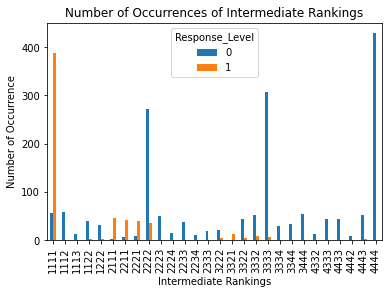

Optimization terminated successfully.
         Current function value: 0.213115
         Iterations 9
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.624    
Dependent Variable:  Response_Level   AIC:              1017.1794
Date:                2021-12-05 14:59 BIC:              1046.0179
No. Observations:    2363             Log-Likelihood:   -503.59  
Df Model:            4                LL-Null:          -1341.0  
Df Residuals:        2358             LLR p-value:      0.0000   
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      9.0000                                      
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Categorical_code -0.5944   0.0286 -20.8108 0.0000 -0.6504 -0.5384
rank_lap1         3.5831   0.3148  11.3837 0.0000  2.9662  4.2000


,Categorical_code,rank_lap1,rank_lap2,rank_lap3,rank_lap4,Probabilty of loss,Probabilty of win
1727,5,2.0,1.0,1.0,1.0,0.097135,0.902865
1164,15,3.0,3.0,2.0,1.0,0.097418,0.902582
1618,6,2.0,2.0,1.0,1.0,0.102503,0.897497
667,7,2.0,2.0,2.0,1.0,0.141508,0.858492
1629,0,1.0,1.0,1.0,1.0,0.149628,0.850372
2166,22,4.0,3.0,3.0,2.0,0.784748,0.215252
1458,14,3.0,2.0,2.0,2.0,0.794860,0.205140
1145,16,3.0,3.0,2.0,2.0,0.805121,0.194879
1647,25,4.0,4.0,4.0,2.0,0.848719,0.151281
2094,17,3.0,3.0,3.0,2.0,0.856375,0.143625


In [229]:
# Looking at the classifications of the different intermediate ranking combinations
%matplotlib inline
pd.crosstab(df_ver1['interRanksLabel'],df_ver1['Response_Level']).plot(kind='bar')
plt.xlabel('Intermediate Rankings')
plt.ylabel('Number of Occurrence')
plt.title('Number of Occurrences of Intermediate Rankings')
plt.show()

# APPLYING THE LOGISTIC REGRESSION MODEL

cols = ['Categorical_code', 'rank_lap1', 'rank_lap2', 'rank_lap3', 'rank_lap4']
X=df_ver1[cols]
y=df_ver1.Response_Level
logit_model=sm.Logit(y,X)
result=logit_model.fit()

# Evaluating the p-values
print(result.summary2())

# Training the model
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

# Displays the probabilities of each intermediate ranking combinations
i=0;
df_probs = pd.DataFrame(X_test.drop_duplicates())
predicted_probs = logreg.predict_proba(X_test.drop_duplicates())
loss_prob = [None]*len(predicted_probs)
win_prob = [None]*len(predicted_probs)
while (i < len(loss_prob)):
    loss_prob[i]= predicted_probs[i][0]
    win_prob[i]= predicted_probs[i][1]
    i=i+1
df_probs['Probabilty of loss'] = loss_prob
df_probs['Probabilty of win'] = win_prob
df_probs.sort_values(by=['Probabilty of loss'])

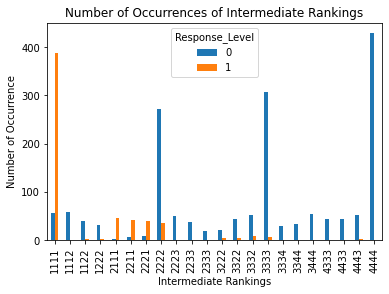

Optimization terminated successfully.
         Current function value: 0.211966
         Iterations 8
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.628    
Dependent Variable:  Response_Level   AIC:              979.1066 
Date:                2021-12-05 14:59 BIC:              1007.7794
No. Observations:    2286             Log-Likelihood:   -484.55  
Df Model:            4                LL-Null:          -1302.2  
Df Residuals:        2281             LLR p-value:      0.0000   
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      8.0000                                      
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Categorical_code -0.7531   0.0361 -20.8546 0.0000 -0.8239 -0.6823
rank_lap1         3.7301   0.3286  11.3529 0.0000  3.0861  4.3740


,Categorical_code,rank_lap1,rank_lap2,rank_lap3,rank_lap4,Probabilty of loss,Probabilty of win
811,4,2.0,1.0,1.0,1.0,0.104788,0.895212
1227,5,2.0,2.0,1.0,1.0,0.121962,0.878038
1380,6,2.0,2.0,2.0,1.0,0.130894,0.869106
893,0,1.0,1.0,1.0,1.0,0.164890,0.835110
70,11,3.0,2.0,2.0,2.0,0.775143,0.224857
944,12,3.0,3.0,2.0,2.0,0.803565,0.196435
582,13,3.0,3.0,3.0,2.0,0.816023,0.183977
711,7,2.0,2.0,2.0,2.0,0.853263,0.146737
10,1,1.0,1.0,1.0,2.0,0.884037,0.115963
1547,2,1.0,1.0,2.0,2.0,0.892076,0.107924


In [230]:
# 2nd ATTEMPT TO MAKE A LOGISTIC REGRESSION WITH THE DATA:
# For the intermediate ranking combinations, values that occur < 20 times in the data set will be removed 
df_ver2 = df

# PREPARING THE VARIABLES FOR THE LOGISTIC REGRESSION:
# The predictor and response variables are defined in the same way as the previous attempt 
    
# CATEGORICAL PREDICTOR VARIABLE
# Combinations of intermediate rankings (value format: <rank in lap 1><rank in lap 2><rank in lap 3><rank in lap 4>)
interRanksLabel = [None]*df_ver2['City'].count()
for index, row in df_ver2.iterrows():  
    interRanksLabel[index] = str(int(row["rank_lap1"])) + str(int(row["rank_lap2"])) + str(int(row["rank_lap3"])) + str(int(row["rank_lap4"]))
df_ver2['interRanksLabel'] = interRanksLabel

# We end up with 89 different values for the categorical variable. To avoid overfitting the model, we remove values
# with occurences < 20
value_counts = df_ver2['interRanksLabel'].value_counts()
to_remove = value_counts[value_counts < 20].index
df_ver2 = df_ver2[~df_ver2.interRanksLabel.isin(to_remove)]
df_ver2 = df_ver2.reset_index(drop=True)

# Encoding the categorical values:
# We will use label encoding to encode the categorical values for logistic regression
df_ver2["interRanksLabel"] = df_ver2["interRanksLabel"].astype('category')
df_ver2["Categorical_code"] = df_ver2["interRanksLabel"].cat.codes


# RESPONSE VARIABLE
# The rankings for the last lap:
    # 0 if the skater did not finish the race in 1st place 
    # 1 if the skater finished the race in 1st place 
interRespLabel = [None]*df_ver2['City'].count()
for index, row in df_ver2.iterrows(): 
    if (row["rank_lap5"] != 1):
        interRespLabel[index] = 0
    else:
        interRespLabel[index] = 1
df_ver2["Response_Level"] = interRespLabel

# Looking at the classifications of the different intermediate rankings
%matplotlib inline
pd.crosstab(df_ver2['interRanksLabel'],df_ver2['Response_Level']).plot(kind='bar')
plt.xlabel('Intermediate Rankings')
plt.ylabel('Number of Occurrence')
plt.title('Number of Occurrences of Intermediate Rankings')
plt.show()

# APPLYING THE LOGISTIC REGRESSION MODEL

cols = ['Categorical_code', 'rank_lap1', 'rank_lap2', 'rank_lap3', 'rank_lap4']
X2=df_ver2[cols]
y2=df_ver2.Response_Level
logit_model2=sm.Logit(y2,X2)
result2=logit_model2.fit()

# Evaluating the p-values
print(result2.summary2())

# Training the model
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train2, y_train2)

y_pred2 = logreg.predict(X_test2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test2, y_test2)))
# Displays the probabilities of each intermediate ranking combinations
i=0;
df_probs2 = pd.DataFrame(X_test2.drop_duplicates())
predicted_probs2 = logreg.predict_proba(X_test2.drop_duplicates())
loss_prob2 = [None]*len(predicted_probs2)
win_prob2 = [None]*len(predicted_probs2)
while (i < len(loss_prob2)):
    loss_prob2[i]= predicted_probs2[i][0]
    win_prob2[i]= predicted_probs2[i][1]
    i=i+1
df_probs2['Probabilty of loss'] = loss_prob2
df_probs2['Probabilty of win'] = win_prob2
df_probs2.sort_values(by=['Probabilty of loss'])

In [210]:
# The results of the second attempt are similar to the first (the same rankings combinations have the 
# highest probabilities of finishing the race in 1st place)

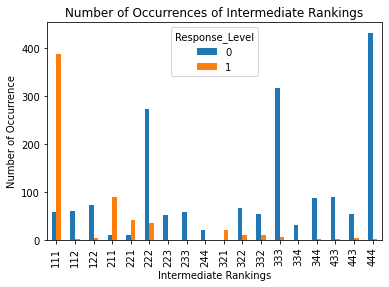

Optimization terminated successfully.
         Current function value: 0.216278
         Iterations 9
                         Results: Logit
Model:               Logit            Pseudo R-squared: 0.623    
Dependent Variable:  Response_Level   AIC:              1024.9388
Date:                2021-12-05 15:00 BIC:              1047.9892
No. Observations:    2351             Log-Likelihood:   -508.47  
Df Model:            3                LL-Null:          -1347.0  
Df Residuals:        2347             LLR p-value:      0.0000   
Converged:           1.0000           Scale:            1.0000   
No. Iterations:      9.0000                                      
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Categorical_code -0.8655   0.0425 -20.3776 0.0000 -0.9488 -0.7823
rank_lap1         3.7947   0.2595  14.6208 0.0000  3.2860  4.3034


,Categorical_code,rank_lap1,rank_lap3,rank_lap4,Probabilty of loss,Probabilty of win
762,9,3.0,2.0,1.0,0.076717,0.923283
1319,3,2.0,1.0,1.0,0.112053,0.887947
442,4,2.0,2.0,1.0,0.115501,0.884499
57,0,1.0,1.0,1.0,0.152532,0.847468
70,10,3.0,2.0,2.0,0.793222,0.206778
195,11,3.0,3.0,2.0,0.798775,0.201225
666,5,2.0,2.0,2.0,0.857726,0.142274
1636,1,1.0,1.0,2.0,0.892582,0.107418
646,2,1.0,2.0,2.0,0.895817,0.104183
1627,15,4.0,3.0,3.0,0.992277,0.007723


In [231]:
# 3rd ATTEMPT TO MAKE A LOGISTIC REGRESSION WITH THE DATA:
# Since the 2nd lap has a p-value < 0.05, it will not be considered as a predictor variable
df_ver3 = df

# PREPARING THE VARIABLES FOR THE LOGISTIC REGRESSION:
# The predictor and response variables are defined in the same way as the previous attempt 
    
# CATEGORICAL PREDICTOR VARIABLE
# Combinations of intermediate rankings (value format: <rank in lap 1><rank in lap 3><rank in lap 4>)
interRanksLabel = [None]*df_ver3['City'].count()
for index, row in df_ver3.iterrows():  
    interRanksLabel[index] = str(int(row["rank_lap1"])) + str(int(row["rank_lap3"])) + str(int(row["rank_lap4"]))
df_ver3['interRanksLabel'] = interRanksLabel

# We end up with 89 different values for the categorical variable. To avoid overfitting the model, we remove values
# with occurences < 20
value_counts = df_ver3['interRanksLabel'].value_counts()
to_remove = value_counts[value_counts < 20].index
df_ver3 = df_ver3[~df_ver3.interRanksLabel.isin(to_remove)]
df_ver3 = df_ver3.reset_index(drop=True)

# Encoding the categorical values:
# We will use label encoding to encode the categorical values for logistic regression
df_ver3["interRanksLabel"] = df_ver3["interRanksLabel"].astype('category')
df_ver3["Categorical_code"] = df_ver3["interRanksLabel"].cat.codes


# RESPONSE VARIABLE
# The rankings for the last lap:
    # 0 if the skater did not finish the race in 1st place 
    # 1 if the skater finished the race in 1st place 
interRespLabel = [None]*df_ver3['City'].count()
for index, row in df_ver3.iterrows(): 
    if (row["rank_lap5"] != 1):
        interRespLabel[index] = 0
    else:
        interRespLabel[index] = 1
df_ver3["Response_Level"] = interRespLabel

# Looking at the classifications of the different intermediate rankings
%matplotlib inline
pd.crosstab(df_ver3['interRanksLabel'],df_ver3['Response_Level']).plot(kind='bar')
plt.xlabel('Intermediate Rankings')
plt.ylabel('Number of Occurrence')
plt.title('Number of Occurrences of Intermediate Rankings')
plt.show()

# APPLYING THE LOGISTIC REGRESSION MODEL

cols = ['Categorical_code', 'rank_lap1', 'rank_lap3', 'rank_lap4']
X3=df_ver3[cols]
y3=df_ver3.Response_Level
logit_model3=sm.Logit(y3,X3)
result3=logit_model3.fit()

# Evaluating the p-values
print(result3.summary2())

# Training the model
X_train3,X_test3,y_train3,y_test3=train_test_split(X3,y3,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train3, y_train3)

y_pred3 = logreg.predict(X_test3)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test3, y_test3)))
# Displays the probabilities of each intermediate ranking combinations
i=0;
df_probs3 = pd.DataFrame(X_test3.drop_duplicates())
predicted_probs3 = logreg.predict_proba(X_test3.drop_duplicates())
loss_prob3 = [None]*len(predicted_probs3)
win_prob3 = [None]*len(predicted_probs3)
while (i < len(loss_prob3)):
    loss_prob3[i]= predicted_probs3[i][0]
    win_prob3[i]= predicted_probs3[i][1]
    i=i+1
df_probs3['Probabilty of loss'] = loss_prob3
df_probs3['Probabilty of win'] = win_prob3
df_probs3.sort_values(by=['Probabilty of loss'])